In [118]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import xgboost

In [119]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1) Read in data & explore preliminarily

In [120]:
df = pd.read_csv('home_sales_dataset.csv')
print(df.shape)
df.head()

(1011, 18)


,sold_price,beds,baths,hm_sqft,lot_size,yr_built,zipcode,pool,garage,stories,schools,sold_date,address,days_on_mkt,hoa,url,lat,lon
0,970000,4,3.0,1933,6999,1960,91364,1,1,1,6.4,August-24-2021,22247 De La Osa St,3,0,http://www.redfin.com/CA/Woodland-Hills/22247-...,34.159168,-118.611596
1,900000,3,2.0,1519,11761,1974,91304,1,1,1,6.4,August-24-2021,7631 Atron Ave,3,0,http://www.redfin.com/CA/Canoga-Park/7631-Atro...,34.209223,-118.637737
2,830000,3,2.0,1595,10560,1960,91303,1,1,1,4.8,August-23-2021,22221 Vanowen St,4,0,http://www.redfin.com/CA/Canoga-Park/22221-Van...,34.193982,-118.611141
3,820000,3,2.5,1364,7253,1959,91307,0,0,1,7.0,August-23-2021,23433 Victory Blvd,4,0,http://www.redfin.com/CA/West-Hills/23433-Vict...,34.186740,-118.637805
4,940553,4,2.5,2018,9347,1960,91367,1,1,1,6.8,August-23-2021,23952 Oxnard St,4,0,http://www.redfin.com/CA/Woodland-Hills/23952-...,34.179507,-118.649017


In [121]:
df['sold_date'] = pd.to_datetime(df['sold_date'])

In [122]:
df.head()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,zipcode,pool,garage,stories,schools,sold_date,address,days_on_mkt,hoa,url,lat,lon
0,970000,4,3.0,1933,6999,1960,91364,1,1,1,6.4,2021-08-24,22247 De La Osa St,3,0,http://www.redfin.com/CA/Woodland-Hills/22247-...,34.159168,-118.611596
1,900000,3,2.0,1519,11761,1974,91304,1,1,1,6.4,2021-08-24,7631 Atron Ave,3,0,http://www.redfin.com/CA/Canoga-Park/7631-Atro...,34.209223,-118.637737
2,830000,3,2.0,1595,10560,1960,91303,1,1,1,4.8,2021-08-23,22221 Vanowen St,4,0,http://www.redfin.com/CA/Canoga-Park/22221-Van...,34.193982,-118.611141
3,820000,3,2.5,1364,7253,1959,91307,0,0,1,7.0,2021-08-23,23433 Victory Blvd,4,0,http://www.redfin.com/CA/West-Hills/23433-Vict...,34.186740,-118.637805
4,940553,4,2.5,2018,9347,1960,91367,1,1,1,6.8,2021-08-23,23952 Oxnard St,4,0,http://www.redfin.com/CA/Woodland-Hills/23952-...,34.179507,-118.649017


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sold_price   1011 non-null   int64         
 1   beds         1011 non-null   int64         
 2   baths        1011 non-null   float64       
 3   hm_sqft      1011 non-null   int64         
 4   lot_size     1011 non-null   int64         
 5   yr_built     1011 non-null   int64         
 6   zipcode      1011 non-null   int64         
 7   pool         1011 non-null   int64         
 8   garage       1011 non-null   int64         
 9   stories      1011 non-null   int64         
 10  schools      1011 non-null   float64       
 11  sold_date    1011 non-null   datetime64[ns]
 12  address      1011 non-null   object        
 13  days_on_mkt  1011 non-null   int64         
 14  hoa          1011 non-null   int64         
 15  url          1011 non-null   object        
 16  lat   

In [124]:
df.drop(columns=['zipcode', 'lat', 'lon']).describe()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,pool,garage,stories,schools,days_on_mkt,hoa
count,1.011000e+03,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,1.126206e+06,3.633037,2.544510,2081.720079,10828.724036,1960.297725,0.134520,0.140455,1.178042,5.738731,44.678536,2.430267
std,5.022851e+05,0.844819,0.924634,886.574023,15533.545033,11.616964,0.341379,0.347630,0.387876,0.674897,24.281487,24.731666
min,4.000000e+05,1.000000,1.000000,552.000000,2000.000000,1920.000000,0.000000,0.000000,1.000000,4.200000,1.000000,0.000000
25%,8.400000e+05,3.000000,2.000000,1471.000000,7083.000000,1954.000000,0.000000,0.000000,1.000000,5.200000,25.000000,0.000000
50%,9.650000e+05,4.000000,2.000000,1873.000000,8217.000000,1958.000000,0.000000,0.000000,1.000000,5.666667,44.000000,0.000000
75%,1.260000e+06,4.000000,3.000000,2447.000000,11761.000000,1964.000000,0.000000,0.000000,1.000000,6.166667,64.000000,0.000000
max,5.500000e+06,8.000000,8.000000,8189.000000,475675.000000,2021.000000,1.000000,1.000000,3.000000,7.666667,90.000000,585.000000


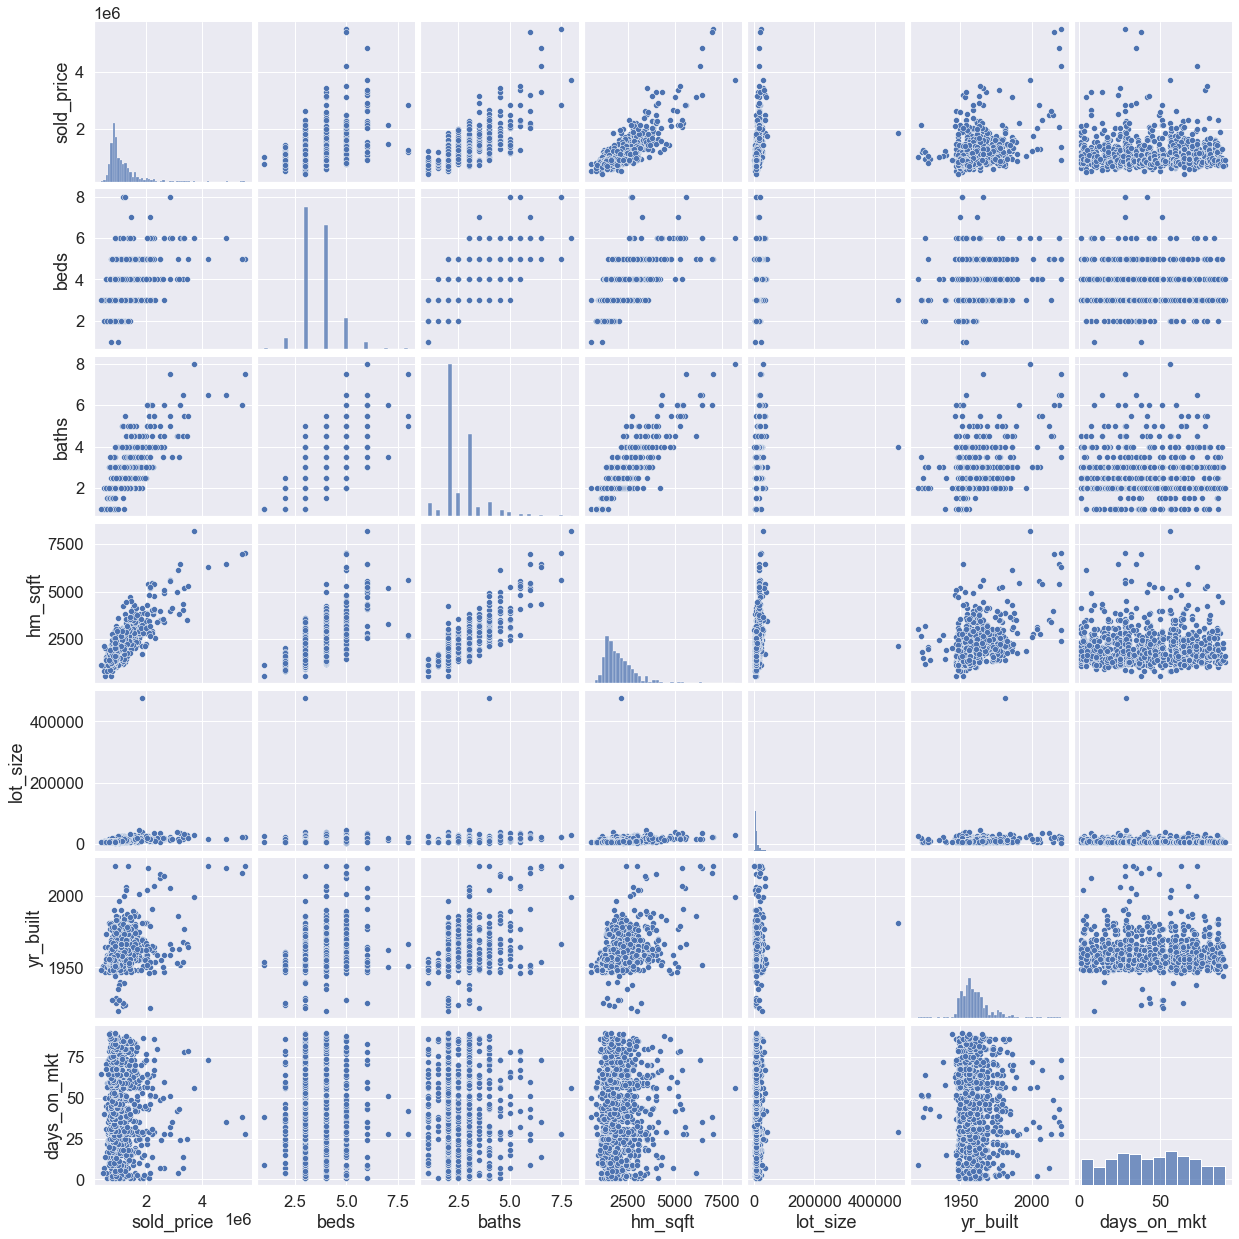

In [125]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'days_on_mkt']);

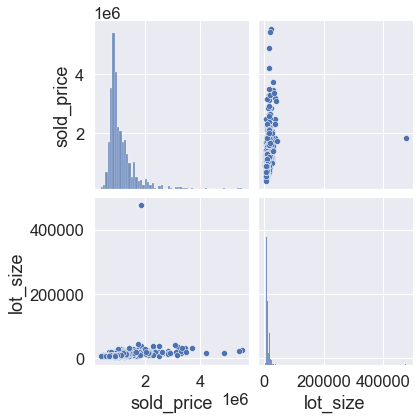

In [126]:
sns.set(font_scale=1.5)
sns.pairplot(data = df, 
             vars = ['sold_price', 'lot_size'],
             height=3);

#### Drop that one home with a huge lot_size from the dataset (obvious undesirable outlier, not representative of vast majority)

In [127]:
print(df.shape)
df = df[df['lot_size'] < 200000]
df.reset_index(drop=True, inplace=True)
print(df.shape)

(1011, 18)
(1010, 18)


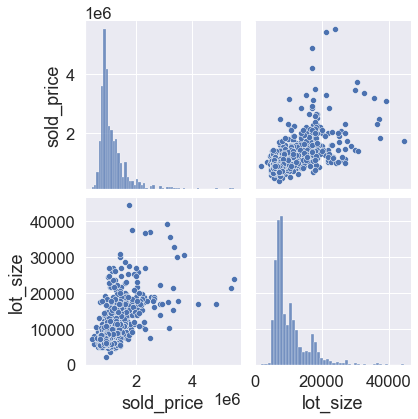

In [128]:
sns.set(font_scale=1.5)
sns.pairplot(data = df, 
             vars = ['sold_price', 'lot_size'],
             height=3);

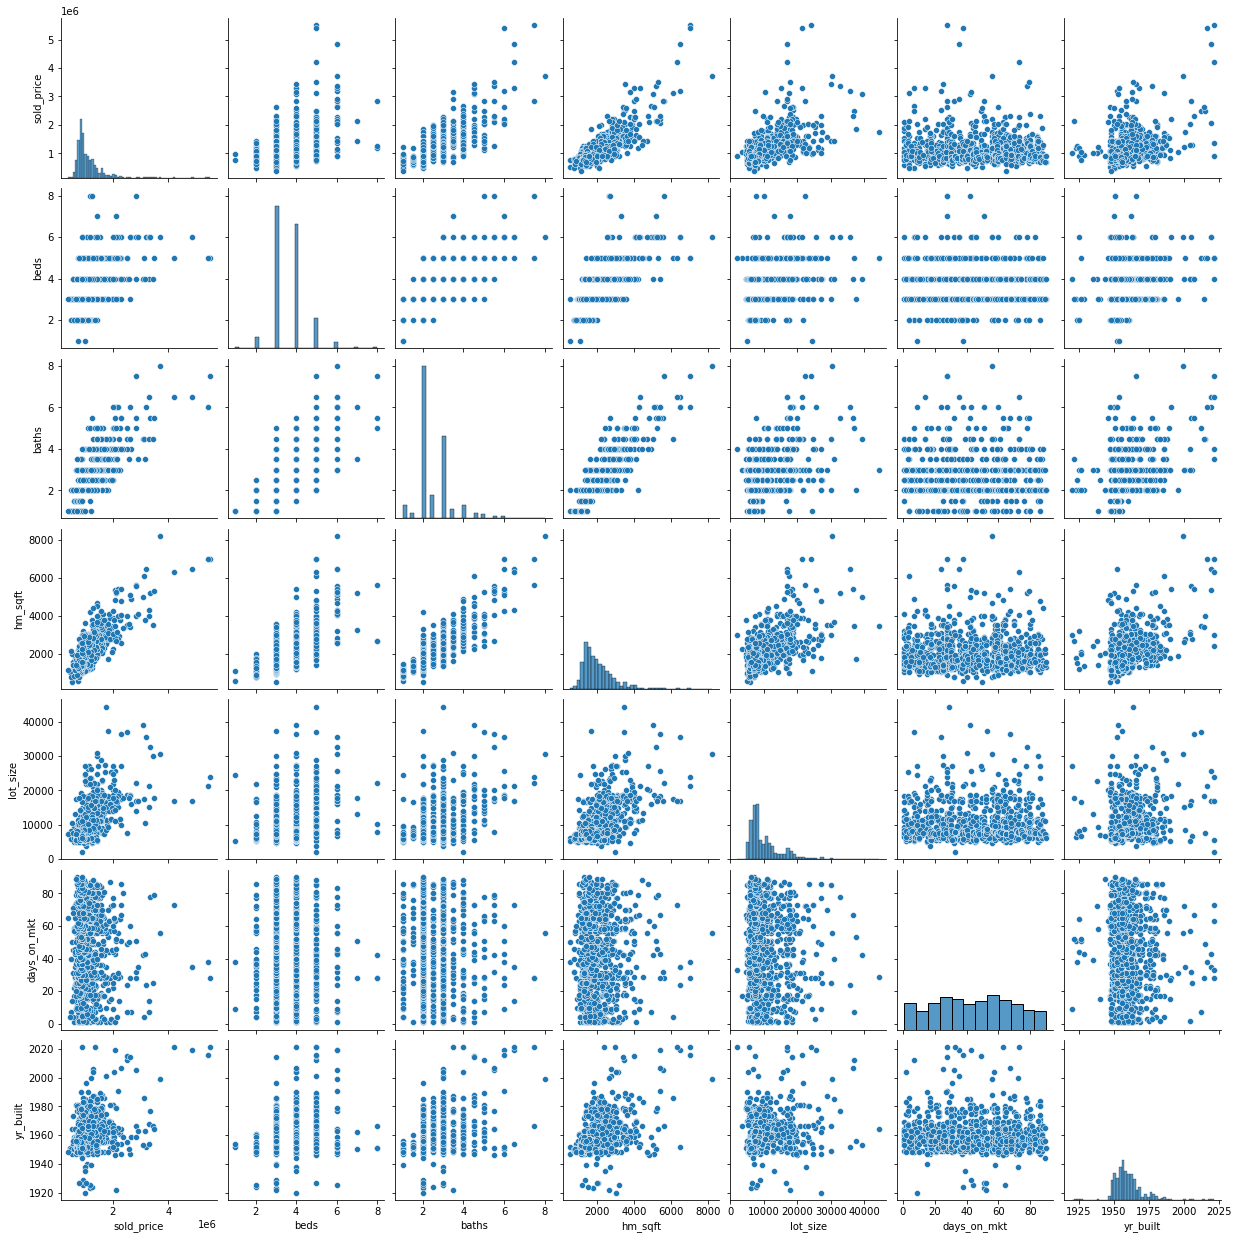

In [11]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'days_on_mkt', 'yr_built']);

In [12]:
df[['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'days_on_mkt']].corr()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,days_on_mkt
sold_price,1.000000,0.468586,0.747992,0.836873,0.616309,0.405557,-0.015035
beds,0.468586,1.000000,0.677780,0.673701,0.353676,0.330157,-0.003969
baths,0.747992,0.677780,1.000000,0.853740,0.506800,0.425517,-0.003983
hm_sqft,0.836873,0.673701,0.853740,1.000000,0.611860,0.482993,-0.012386
lot_size,0.616309,0.353676,0.506800,0.611860,1.000000,0.235796,-0.011387
yr_built,0.405557,0.330157,0.425517,0.482993,0.235796,1.000000,-0.031676
days_on_mkt,-0.015035,-0.003969,-0.003983,-0.012386,-0.011387,-0.031676,1.000000


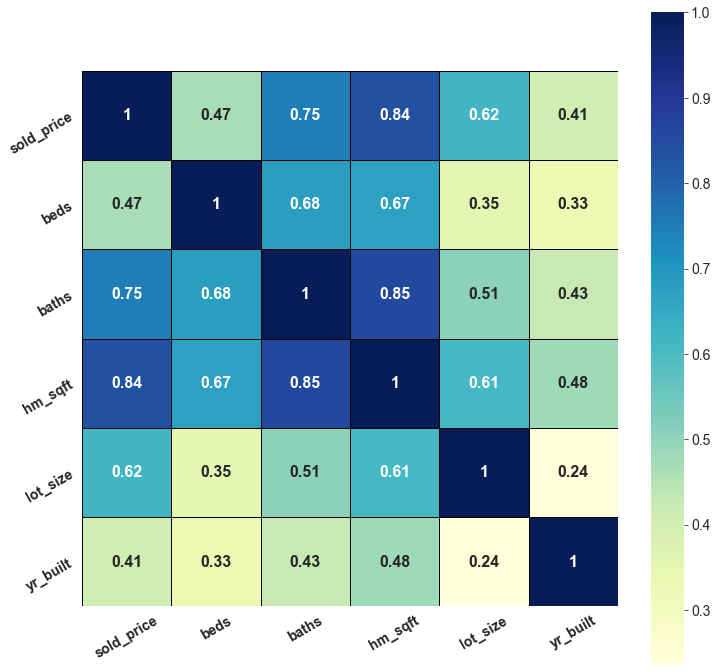

In [106]:
plt.figure(figsize=(12,12))

data = df[['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built']]
g = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True, linewidth=1, linecolor='black', 
            annot_kws={"size": 16, 'fontweight': 'bold'}, square=True)
g.set_xticklabels(g.get_xticklabels(), rotation=30, size=14, fontweight='bold')
g.set_yticklabels(g.get_yticklabels(), rotation=30, size=14, fontweight='bold')
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=14);


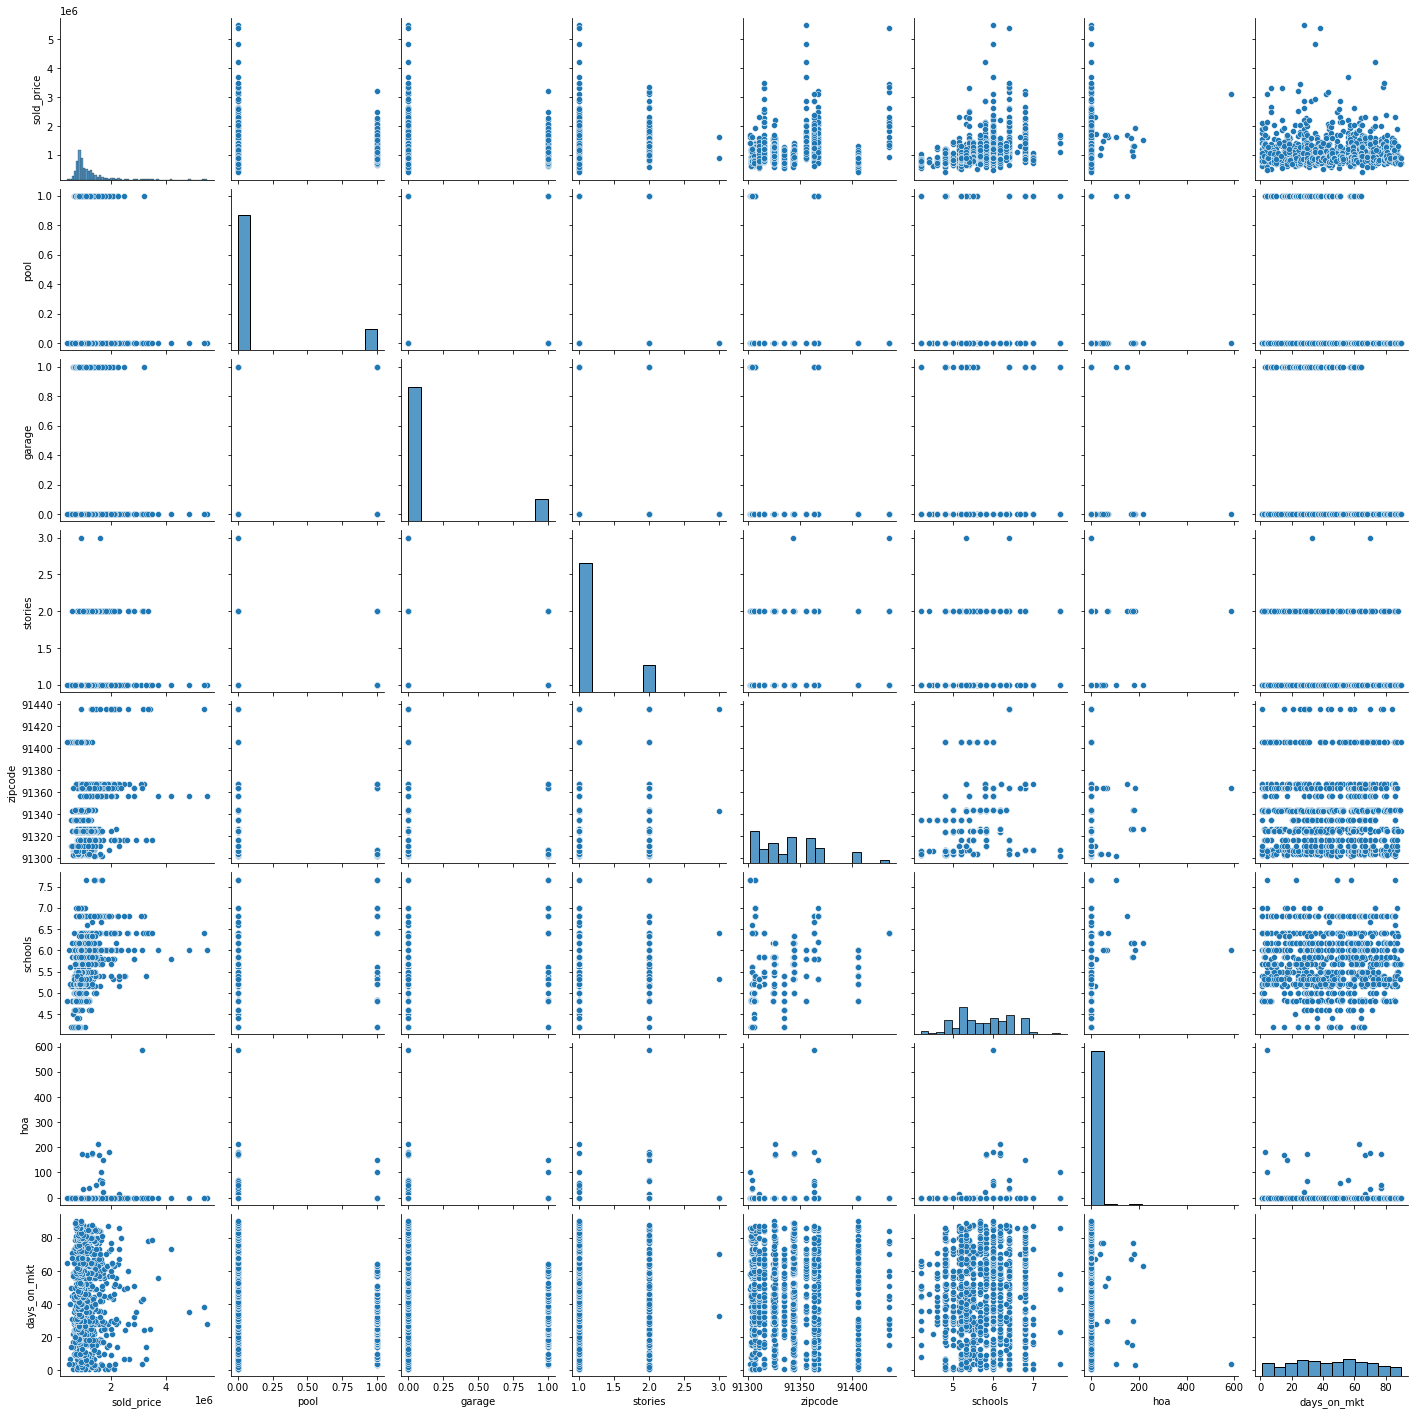

In [12]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa', 'days_on_mkt']);

In [13]:
df[['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa', 'days_on_mkt']].corr()

,sold_price,pool,garage,stories,zipcode,schools,hoa,days_on_mkt
sold_price,1.000000,0.028298,0.025144,0.187080,0.219329,0.356463,0.143552,-0.015035
pool,0.028298,1.000000,0.950247,0.074175,-0.100235,0.268048,-0.009247,-0.219170
garage,0.025144,0.950247,1.000000,0.057655,-0.096038,0.280840,-0.010762,-0.225222
stories,0.187080,0.074175,0.057655,1.000000,-0.028739,0.177494,0.136809,-0.051873
zipcode,0.219329,-0.100235,-0.096038,-0.028739,1.000000,0.267983,0.006319,-0.012574
schools,0.356463,0.268048,0.280840,0.177494,0.267983,1.000000,0.061756,-0.026134
hoa,0.143552,-0.009247,-0.010762,0.136809,0.006319,0.061756,1.000000,-0.042238
days_on_mkt,-0.015035,-0.219170,-0.225222,-0.051873,-0.012574,-0.026134,-0.042238,1.000000


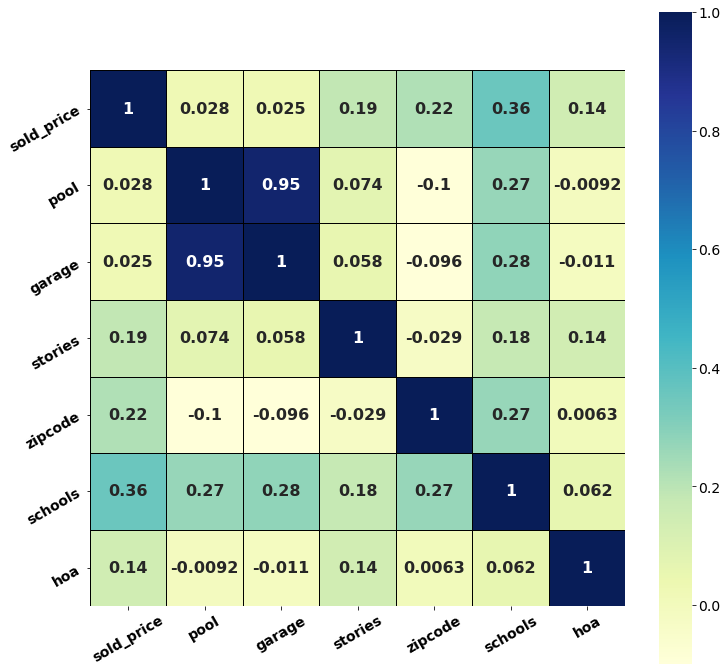

In [67]:
plt.figure(figsize=(12,12))

data = df[['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa']]
g = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True, linewidth=1, linecolor='black', 
            annot_kws={"size": 16, 'fontweight': 'bold'}, square=True)
g.set_xticklabels(g.get_xticklabels(), rotation=30, size=14, fontweight='bold')
g.set_yticklabels(g.get_yticklabels(), rotation=30, size=14, fontweight='bold')
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=14);

# Early conclusion: days_on_mkt (and alternative target) is uniformly distributed & pretty much uncorrelated w/ everything else!

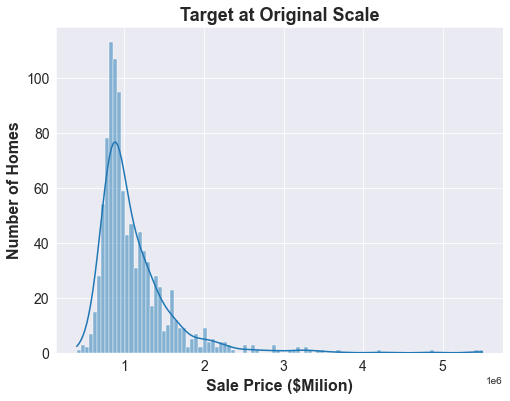

In [69]:
sns.set_style("darkgrid")
plt.figure(figsize=(8,6))

sns.histplot(data=df['sold_price'], bins=100, kde=True)
plt.xlabel('Sale Price ($Milion)', size=16, fontweight='bold')
plt.ylabel('Number of Homes', size=16, fontweight='bold')
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Target at Original Scale', size=18, fontweight='bold');

#### Perhaps log transforming the target can lead to a better model

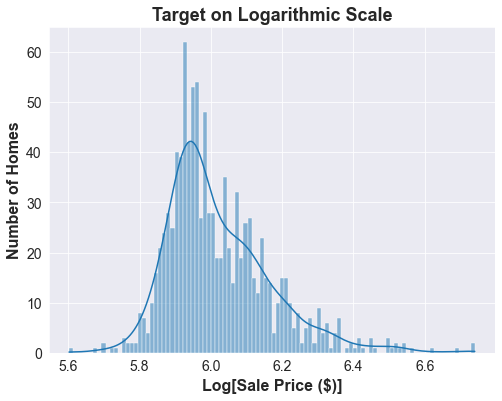

In [102]:
sns.set_style("darkgrid")
plt.figure(figsize=(8,6))

sns.histplot(data=np.log10(df['sold_price']), bins=100, kde=True)
plt.xlabel('Log[Sale Price ($)]', size=16, fontweight='bold')
plt.ylabel('Number of Homes', size=16, fontweight='bold')
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Target on Logarithmic Scale', size=18, fontweight='bold');

# 2) Feature Engineering (part 1)

### Start with appropriate one-hot encoding: zipcode

In [71]:
df_data = pd.get_dummies(data=df[['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 
                                  'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa']], 
                         columns=['zipcode'], 
                         drop_first=True)

### Change 'stories' to binary variable 'one_story' (1 = yes, 0 = no => multi-story)

In [72]:
df_data['stories'].value_counts()

1    833
2    175
3      2
Name: stories, dtype: int64

In [73]:
df_data.loc[df_data['stories'] > 1, 'stories'] = 0
df_data.rename(columns={'stories': 'one_story'}, inplace=True)
df_data.head()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,pool,garage,one_story,schools,hoa,zipcode_91303,zipcode_91304,zipcode_91306,zipcode_91307,zipcode_91311,zipcode_91316,zipcode_91324,zipcode_91325,zipcode_91326,zipcode_91335,zipcode_91343,zipcode_91344,zipcode_91356,zipcode_91364,zipcode_91367,zipcode_91406,zipcode_91436
0,970000,4,3.0,1933,6999,1960,1,1,1,6.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,900000,3,2.0,1519,11761,1974,1,1,1,6.4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,830000,3,2.0,1595,10560,1960,1,1,1,4.8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,820000,3,2.5,1364,7253,1959,0,0,1,7.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,940553,4,2.5,2018,9347,1960,1,1,1,6.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [74]:
df_data['one_story'].value_counts()

1    833
0    177
Name: one_story, dtype: int64

# 3) Baseline Features for Modeling

#### Define a Diagnostic Plot Function 
##### (adapted from func of same name provided in Metis linear assumptions & testing notebook)

In [75]:
def diagnostic_plots(x, y, y_pred):    
    
    plt.figure(figsize=(20,5))
    plt.tight_layout(pad=10.0)
    
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred,y)
    plt.plot([0, 3.5e6], [0, 3.5e6], color='r', linestyle='--')
    plt.title('Pred. vs. True Sale Price', fontweight='bold', size=18)
    plt.xlabel("Predicted", fontweight='bold', size=16)
    plt.ylabel("True Sale Price", fontweight='bold', size=16)
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.grid(True, linestyle='--')
    
    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res)
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.title("Residuals plot", fontweight='bold', size=18)
    plt.xlabel("Predicted", fontweight='bold', size=16)
    plt.ylabel("Residual", fontweight='bold', size=16)
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.grid(True, linestyle='--')
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot", fontweight='bold', size=18)
    plt.xlabel('Theoretical Quantiles', fontweight='bold', size=16)
    plt.ylabel('Ordered Values', fontweight='bold', size=16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.grid(True, linestyle='--')

In [76]:
def cv_rsquareds(x, y, model, cv):    
    scores = cross_val_score(model, x, y, scoring='r2', cv=cv)
    scores = [round(val, 3) for val in scores]
    
    print('CV R-squareds: {}'.format(scores)) 
    print('Mean CV R-squared: {} +/- {}'.format(round(np.mean(scores), 3), round(np.std(scores), 3)))
    
    n = x.shape[0]
    p = x.shape[1]
    adj_r_squareds = [round(1 - (1 - r_squared)*((n - 1)/(n - p - 1)), 3) for r_squared in scores]
    print('\nAdjusted CV R-squareds: {}'.format(adj_r_squareds))
    print('Mean Adjusted CV R-squared: {} +/- {}'.format(round(np.mean(adj_r_squareds), 3), 
                                                         round(np.std(adj_r_squareds), 3)))

In [77]:
def cv_maes(x, y, model, cv):
    scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv)
    scores = [round(val) for val in scores]
    
    print('\nCV MAEs: {}'.format([-1*score for score in scores])) 
    print('Mean CV MAE: {} +/- {}'.format(-1*round(np.mean(scores)), round(np.std(scores))))

### Split into CV and Test Sets (will NOT touch Test set until final model has been chosen and tuned!)

In [78]:
X = df_data.drop(columns='sold_price')
y = df_data['sold_price']

In [79]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Baseline Model 1: Linear Model, all features

In [80]:
model_1 = LinearRegression()

cv_rsquareds(X_cv, y_cv, model_1, 5)
cv_maes(X_cv, y_cv, model_1, 5)

CV R-squareds: [0.809, 0.815, 0.852, 0.82, 0.833]
Mean CV R-squared: 0.826 +/- 0.015

Adjusted CV R-squareds: [0.802, 0.809, 0.847, 0.814, 0.827]
Mean Adjusted CV R-squared: 0.82 +/- 0.016

CV MAEs: [151297, 127315, 122928, 140177, 139250]
Mean CV MAE: 136193 +/- 10081


Basic Linear Model: Mean CV R-squared = 0.826 +/- 0.015
Basic Linear Model: Mean CV MAE = $136193 +/- $10081
Basic Linear Model: Mean CV RMSE = $197568 +/- $27254


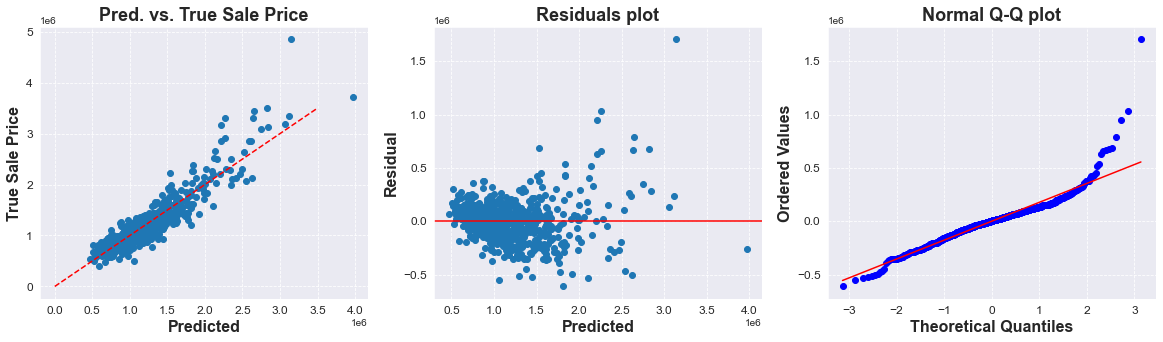

In [81]:
# For final slide deck

model_1.fit(X_cv, y_cv)

y_pred = model_1.predict(X_cv)

scores = cross_val_score(model_1, X_cv, y_cv, scoring='r2', cv=5)
scores = [round(val, 3) for val in scores]
print('Basic Linear Model: Mean CV R-squared = {} +/- {}'
      .format(round(np.mean(scores), 3), round(np.std(scores), 3)))

scores = cross_val_score(model_1, X_cv, y_cv, 
                         scoring='neg_mean_absolute_error', 
                         cv=5)
scores = [round(val) for val in scores]
print('Basic Linear Model: Mean CV MAE = ${} +/- ${}'.format(
    -1*round(np.mean(scores)), round(np.std(scores))))

scores = cross_val_score(model_1, X_cv, y_cv, 
                         scoring='neg_mean_squared_error', 
                         cv=5)
scores = [round(-np.sqrt(-val)) for val in scores]
print('Basic Linear Model: Mean CV RMSE = ${} +/- ${}'.format(
    -1*round(np.mean(scores)), round(np.std(scores))))

diagnostic_plots(X_cv, y_cv, y_pred)

In [82]:
X_cv.columns

Index(['beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'pool', 'garage',
       'one_story', 'schools', 'hoa', 'zipcode_91303', 'zipcode_91304',
       'zipcode_91306', 'zipcode_91307', 'zipcode_91311', 'zipcode_91316',
       'zipcode_91324', 'zipcode_91325', 'zipcode_91326', 'zipcode_91335',
       'zipcode_91343', 'zipcode_91344', 'zipcode_91356', 'zipcode_91364',
       'zipcode_91367', 'zipcode_91406', 'zipcode_91436'],
      dtype='object')

#### Are the two highest priced predictions  influential points? Let's refit this using statsmodels to find out:

In [83]:
x_cv = sm.add_constant(X_cv)
model = sm.OLS(y_cv, x_cv)
model_1b = model.fit()
model_1b.summary()

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sold_price   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     160.7
Date:                Mon, 13 Sep 2021   Prob (F-statistic):          4.96e-297
Time:                        19:10:16   Log-Likelihood:                -10950.
No. Observations:                 808   AIC:                         2.196e+04
Df Residuals:                     780   BIC:                         2.209e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.714e+06   1.42e+06     -1.910      0.057    -5.5e+06     7.6e+04
beds          -2.896e+04   1.22e+04     -2.372      0.018   -5.29e+04   -4988.630
baths          8.245e+04   1.47e+04      5.601      0.000    5.36e+04    1.11e+05
hm_sqft         297.8425     17.603     16.920      0.000     263.287     332.398
lot_size         16.2650      1.750      9.292      0.000      12.829      19.701
yr_built       1307.2408    729.721      1.791      0.074    -125.209    2739.691
pool          -3.439e+04   6.56e+04     -0.525      0.600   -1.63e+05    9.43e+04
garage         2.571e+04   6.48e+04      0.396      0.692   -1.02e+05    1.53e+05
one_story      1.214e+05   2.05e+04      5.919      0.000    8.12e+04    1.62e+05
schools        8.729e+04   1.67e+04      5.229      0.000    5.45e+04     1.2e+05
hoa             468.1808    253.520      1.847      0.065     -29.482     965.844
zipcode_91303 -1.545e+05   1.16e+05     -1.336      0.182   -3.82e+05    7.26e+04
zipcode_91304 -2.721e+05   1.05e+05     -2.590      0.010   -4.78e+05   -6.58e+04
zipcode_91306  -2.53e+05   1.12e+05     -2.256      0.024   -4.73e+05   -3.29e+04
zipcode_91307 -3.145e+05   1.01e+05     -3.108      0.002   -5.13e+05   -1.16e+05
zipcode_91311  -4.13e+05   1.09e+05     -3.798      0.000   -6.26e+05      -2e+05
zipcode_91316  1.136e+05   1.05e+05      1.081      0.280   -9.27e+04     3.2e+05
zipcode_91324 -2.905e+05   1.11e+05     -2.626      0.009   -5.08e+05   -7.34e+04
zipcode_91325 -3.595e+05   1.06e+05     -3.392      0.001   -5.68e+05   -1.51e+05
zipcode_91326 -3.136e+05   1.02e+05     -3.067      0.002   -5.14e+05   -1.13e+05
zipcode_91335 -1.918e+05   1.09e+05     -1.764      0.078   -4.05e+05    2.17e+04
zipcode_91343 -3.492e+05   1.04e+05     -3.344      0.001   -5.54e+05   -1.44e+05
zipcode_91344 -3.261e+05   1.02e+05     -3.187      0.001   -5.27e+05   -1.25e+05
zipcode_91356  9499.5533   1.06e+05      0.089      0.929   -1.99e+05    2.18e+05
zipcode_91364 -1.642e+05   9.98e+04     -1.645      0.100    -3.6e+05    3.18e+04
zipcode_91367 -1.839e+05   9.93e+04     -1.852      0.064   -3.79e+05     1.1e+04
zipcode_91406 -2.386e+05   1.05e+05     -2.276      0.023   -4.44e+05   -3.28e+04
zipcode_91436  3.271e+05   1.09e+05      2.988      0.003    1.12e+05    5.42e+05
==============================================================================
Omnibus:                      325.718   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4594.486
Skew:                           1.426   Prob(JB):                         0.00
Kurtosis:                      14.328   Cond. No.                     2.56e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of th

In [84]:
influence_frame = model_1b.get_influence().summary_frame()
influence_frame['cooks_d'].sort_values(ascending=False).head()

468    0.343568
413    0.260602
695    0.083939
692    0.057844
414    0.040407
Name: cooks_d, dtype: float64

##### Technically, no influence points (Cook's dist > 0.5), but as suspected, largest Cook's distances are all for sale prices > 3e6

In [85]:
print(y_cv.loc[468])
print(y_cv.loc[413])
print(y_cv.loc[695])
print(y_cv.loc[692])

4850000
3125000
3162000
3445000


In [106]:
df_data[df_data['sold_price'] >= 3e6].shape[0]

14

In [55]:
df_data[['sold_price']].describe()

,sold_price
count,1.010000e+03
mean,1.125490e+06
std,5.020166e+05
min,4.000000e+05
25%,8.400000e+05
50%,9.650000e+05
75%,1.260000e+06
max,5.500000e+06


In [86]:
df_data[df_data['sold_price'] <= 3e6]['sold_price'].describe()

count    9.960000e+02
mean     1.087947e+06
std      3.799263e+05
min      4.000000e+05
25%      8.387500e+05
50%      9.600000e+05
75%      1.250000e+06
max      2.919500e+06
Name: sold_price, dtype: float64

#### While we're here, what about colinearity (VIF)?

In [87]:
variables = model_1b.model.exog

# Don't count the intercept! (index=0)
vifs = [variance_inflation_factor(variables, i) for i in range(1, variables.shape[1])]
list(zip(X_cv.columns, vifs))

[('beds', 2.3748583643981656),
 ('baths', 4.072735302379183),
 ('hm_sqft', 5.437264869722127),
 ('lot_size', 1.8733264817992954),
 ('yr_built', 1.5700897667828313),
 ('pool', 11.57502382688967),
 ('garage', 11.747185650226495),
 ('one_story', 1.3833790612343233),
 ('schools', 2.8474981567584066),
 ('hoa', 1.099961309515748),
 ('zipcode_91303', 6.572944824369663),
 ('zipcode_91304', 17.114664326885844),
 ('zipcode_91306', 9.160317438887061),
 ('zipcode_91307', 14.155094527004882),
 ('zipcode_91311', 9.843143469181072),
 ('zipcode_91316', 12.274967108237547),
 ('zipcode_91324', 6.336828564376861),
 ('zipcode_91325', 10.78526152242736),
 ('zipcode_91326', 13.688698052439177),
 ('zipcode_91335', 14.904258380835545),
 ('zipcode_91343', 14.012337965465685),
 ('zipcode_91344', 23.14157781344486),
 ('zipcode_91356', 9.990088245643582),
 ('zipcode_91364', 22.477096197707578),
 ('zipcode_91367', 19.83941218634806),
 ('zipcode_91406', 17.56390245617648),
 ('zipcode_91436', 5.248328562896553)]

In [97]:
VIF_df = pd.DataFrame(data=list(zip(X_cv.columns,$ vifs)), columns=['Variable', 'VIF'])
VIF_df[0:9]

,Variable,VIF
0,beds,2.374858
1,baths,4.072735
2,hm_sqft,5.437265
3,lot_size,1.873326
4,yr_built,1.570090
5,pool,11.575024
6,garage,11.747186
7,one_story,1.383379
8,schools,2.847498


In [98]:
VIF_df[10:19]

,Variable,VIF
10,zipcode_91303,6.572945
11,zipcode_91304,17.114664
12,zipcode_91306,9.160317
13,zipcode_91307,14.155095
14,zipcode_91311,9.843143
15,zipcode_91316,12.274967
16,zipcode_91324,6.336829
17,zipcode_91325,10.785262
18,zipcode_91326,13.688698


In [100]:
VIF_df[19:]

,Variable,VIF
19,zipcode_91335,14.904258
20,zipcode_91343,14.012338
21,zipcode_91344,23.141578
22,zipcode_91356,9.990088
23,zipcode_91364,22.477096
24,zipcode_91367,19.839412
25,zipcode_91406,17.563902
26,zipcode_91436,5.248329


In [110]:
df_data[['pool', 'garage']].corr()

,pool,garage
pool,1.000000,0.950247
garage,0.950247,1.000000


In [111]:
df_data[['pool', 'garage']].value_counts()

pool  garage
0     0         865
1     1         133
0     1           9
1     0           3
dtype: int64

#### Aha! 'pool' & 'garage' are highly correlated (missed that in the pair plots); let's drop 'pool'

In [112]:
df_data = df_data.drop(columns='pool')

In [113]:
df_data.columns

Index(['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built',
       'garage', 'one_story', 'schools', 'hoa', 'zipcode_91303',
       'zipcode_91304', 'zipcode_91306', 'zipcode_91307', 'zipcode_91311',
       'zipcode_91316', 'zipcode_91324', 'zipcode_91325', 'zipcode_91326',
       'zipcode_91335', 'zipcode_91343', 'zipcode_91344', 'zipcode_91356',
       'zipcode_91364', 'zipcode_91367', 'zipcode_91406', 'zipcode_91436'],
      dtype='object')

#### Now, is there anything we can do about the high VIFs of the zipcode one-hots?

In [114]:
df['zipcode'].value_counts()

91364    120
91344    107
91367     96
91304     75
91406     72
91307     66
91326     65
91343     65
91335     59
91316     53
91356     45
91325     43
91306     40
91311     38
91324     22
91303     21
91436     19
91302      4
Name: zipcode, dtype: int64

In [115]:
df_data[['zipcode_91303', 'zipcode_91304', 'zipcode_91306', 'zipcode_91307', 
     'zipcode_91311', 'zipcode_91316', 'zipcode_91324', 'zipcode_91325', 
     'zipcode_91326', 'zipcode_91335', 'zipcode_91343', 'zipcode_91344', 
     'zipcode_91356', 'zipcode_91364', 'zipcode_91367', 'zipcode_91406', 'zipcode_91436']].corr()

,zipcode_91303,zipcode_91304,zipcode_91306,zipcode_91307,zipcode_91311,zipcode_91316,zipcode_91324,zipcode_91325,zipcode_91326,zipcode_91335,zipcode_91343,zipcode_91344,zipcode_91356,zipcode_91364,zipcode_91367,zipcode_91406,zipcode_91436
zipcode_91303,1.000000,-0.041270,-0.029591,-0.038530,-0.028812,-0.034292,-0.021744,-0.030728,-0.038217,-0.036295,-0.038217,-0.050160,-0.031467,-0.053507,-0.047225,-0.040372,-0.020177
zipcode_91304,-0.041270,1.000000,-0.057513,-0.074888,-0.055999,-0.066651,-0.042263,-0.059724,-0.074279,-0.070544,-0.074279,-0.097493,-0.061160,-0.103997,-0.091788,-0.078467,-0.039216
zipcode_91306,-0.029591,-0.057513,1.000000,-0.053695,-0.040152,-0.047789,-0.030302,-0.042822,-0.053258,-0.050580,-0.053258,-0.069902,-0.043852,-0.074566,-0.065812,-0.056261,-0.028118
zipcode_91307,-0.038530,-0.074888,-0.053695,1.000000,-0.052281,-0.062225,-0.039457,-0.055758,-0.069347,-0.065860,-0.069347,-0.091019,-0.057099,-0.097092,-0.085694,-0.073257,-0.036612
zipcode_91311,-0.028812,-0.055999,-0.040152,-0.052281,1.000000,-0.046531,-0.029505,-0.041695,-0.051856,-0.049249,-0.051856,-0.068062,-0.042697,-0.072603,-0.064080,-0.054780,-0.027378
zipcode_91316,-0.034292,-0.066651,-0.047789,-0.062225,-0.046531,1.000000,-0.035117,-0.049625,-0.061720,-0.058616,-0.061720,-0.081008,-0.050819,-0.086413,-0.076268,-0.065200,-0.032585
zipcode_91324,-0.021744,-0.042263,-0.030302,-0.039457,-0.029505,-0.035117,1.000000,-0.031467,-0.039136,-0.037168,-0.039136,-0.051367,-0.032224,-0.054793,-0.048361,-0.041343,-0.020662
zipcode_91325,-0.030728,-0.059724,-0.042822,-0.055758,-0.041695,-0.049625,-0.031467,1.000000,-0.055305,-0.052524,-0.055305,-0.072589,-0.045537,-0.077431,-0.068341,-0.058423,-0.029199
zipcode_91326,-0.038217,-0.074279,-0.053258,-0.069347,-0.051856,-0.061720,-0.039136,-0.055305,1.000000,-0.065325,-0.068783,-0.090279,-0.056635,-0.096302,-0.084997,-0.072662,-0.036315
zipcode_91335,-0.036295,-0.070544,-0.050580,-0.065860,-0.049249,-0.058616,-0.037168,-0.052524,-0.065325,1.000000,-0.065325,-0.085740,-0.053787,-0.091460,-0.080723,-0.069008,-0.034489


#### Not any obvious correlations above; are these zipcode VIFs really a concern? Will leave this alone for now.

##### Command decision: 'sold_price' >= 3 million is almost 4-sigma from the mean, so let's just drop the 14 >= 3 million dollar homes
##### (i.e. This model is geared towards the much more common lower home prices, not the handful of very high-priced homes)

In [116]:
X = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')
y = df_data[df_data['sold_price'] <= 3e6]['sold_price']

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
model_1c = LinearRegression()

cv_rsquareds(X_cv, y_cv, model_1c, 5)
cv_maes(X_cv, y_cv, model_1c, 5)

CV R-squareds: [0.835, 0.821, 0.827, 0.766, 0.746]
Mean CV R-squared: 0.799 +/- 0.036

Adjusted CV R-squareds: [0.829, 0.815, 0.821, 0.758, 0.737]
Mean Adjusted CV R-squared: 0.792 +/- 0.037

CV MAEs: [136979, 126904, 118123, 109447, 124518]
Mean CV MAE: 123194 +/- 9168


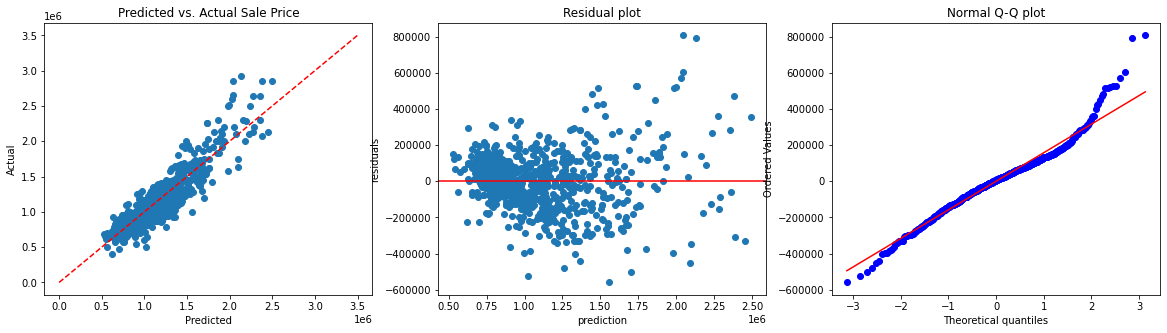

In [118]:
model_1c.fit(X_cv, y_cv)

y_pred = model_1c.predict(X_cv)

diagnostic_plots(X_cv, y_cv, y_pred)

### Model 2: Try adding some further features

#### 'beds', 'baths', 'hm_sqft', 'schools' all show signs of a possible 2nd-order relationship w/ 'sold_price'

In [44]:
df_data['beds_SQ'] = df_data['beds'] * df_data['beds']
df_data['baths_SQ'] = df_data['baths'] * df_data['baths']
df_data['hm_sqft_SQ'] = df_data['hm_sqft'] * df_data['hm_sqft']
df_data['lot_size_SQ'] = df_data['lot_size'] * df_data['lot_size']
df_data['schools_SQ'] = df_data['schools'] * df_data['schools']
df_data['yr_built_SQ'] = df_data['yr_built'] * df_data['yr_built']

In [45]:
X2 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')

X2_cv, X2_test, y2_cv, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [46]:
model_2 = LinearRegression()

cv_rsquareds(X2_cv, y2_cv, model_2, 5)
cv_maes(X2_cv, y2_cv, model_2, 5)

CV R-squareds: [0.848, 0.833, 0.819, 0.769, 0.741]
Mean CV R-squared: 0.802 +/- 0.04

Adjusted CV R-squareds: [0.842, 0.826, 0.811, 0.759, 0.73]
Mean Adjusted CV R-squared: 0.794 +/- 0.042

CV MAEs: [131220, 120503, 117921, 107533, 123583]
Mean CV MAE: 120152 +/- 7728


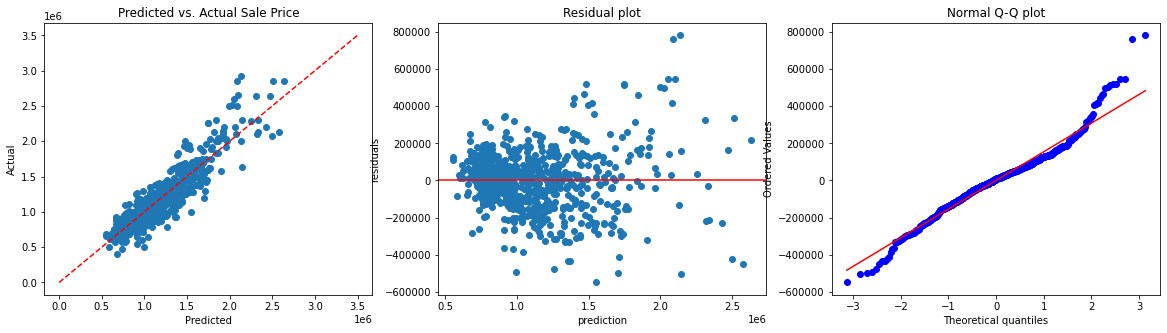

In [71]:
model_2.fit(X2_cv, y2_cv)

y2_pred = model_2.predict(X2_cv)

diagnostic_plots(X2_cv, y2_cv, y2_pred)

In [48]:
list(zip(X2_cv.columns, model_2.coef_))

[('beds', 66476.4366127777),
 ('baths', 27000.959312915784),
 ('hm_sqft', 136.27590810997012),
 ('lot_size', 34.19175378807313),
 ('yr_built', 271.6852468623504),
 ('garage', -3876.1068601975903),
 ('one_story', 67007.3014543652),
 ('schools', -258353.04351731547),
 ('hoa', 74.80569478321567),
 ('zipcode_91303', -240233.70179506953),
 ('zipcode_91304', -296630.8274739762),
 ('zipcode_91306', -315765.9450786597),
 ('zipcode_91307', -341032.3323080951),
 ('zipcode_91311', -356623.0446201239),
 ('zipcode_91316', 95637.53431466484),
 ('zipcode_91324', -288261.92381313146),
 ('zipcode_91325', -334462.73731841834),
 ('zipcode_91326', -294305.03050996526),
 ('zipcode_91335', -222500.1093318273),
 ('zipcode_91343', -357892.2028104377),
 ('zipcode_91344', -326987.267300044),
 ('zipcode_91356', -36884.44888628106),
 ('zipcode_91364', -152053.34808562786),
 ('zipcode_91367', -181279.75205645457),
 ('zipcode_91406', -254642.0544856798),
 ('zipcode_91436', 231665.46998717394),
 ('beds_SQ', -9742.73

### Model 3: Try "Lazy" Lasso (specifically to eliminate some predictors)

In [49]:
X3 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')

X3_cv, X3_test, y3_cv, y3_test = train_test_split(X3, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X3_cv_scaled = scaler.fit_transform(X3_cv)

In [49]:
alphas = 10**np.linspace(-4, 4, 1000)
lasso_model = LassoCV(alphas=alphas, cv=5, normalize=False, max_iter=100000)

lasso_model.fit(X3_cv_scaled, y3_cv)

alpha = round(lasso_model.alpha_, 2)
print('Best alpha: {}'.format(alpha))

Best alpha: 17.27


In [50]:
model_3 = Lasso(alpha=17.27, max_iter=100000)

cv_rsquareds(X3_cv_scaled, y3_cv, model_3, 5)
cv_maes(X3_cv_scaled, y3_cv, model_3, 5)

CV R-squareds: [0.85, 0.83, 0.82, 0.769, 0.744]
Mean CV R-squared: 0.803 +/- 0.04

Adjusted CV R-squareds: [0.844, 0.823, 0.812, 0.759, 0.733]
Mean Adjusted CV R-squared: 0.794 +/- 0.041

CV MAEs: [130824, 121602, 117784, 107541, 123133]
Mean CV MAE: 120177 +/- 7609


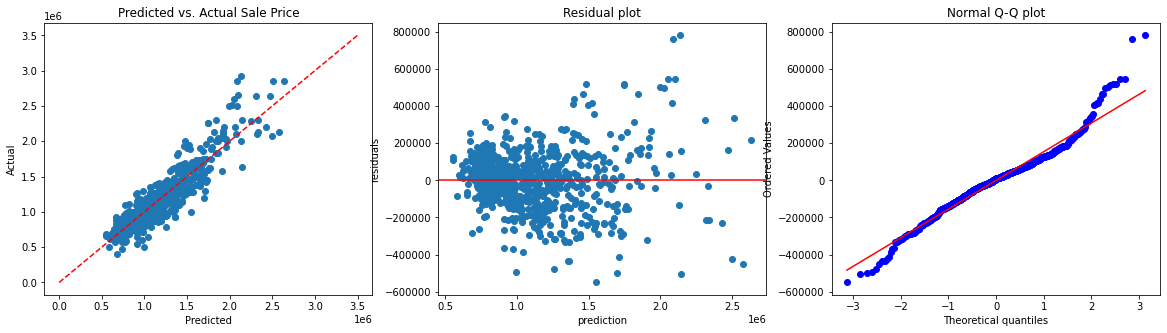

In [72]:
model_3.fit(X3_cv_scaled, y3_cv)

y3_pred = model_3.predict(X3_cv_scaled)

diagnostic_plots(X3_cv, y3_cv, y3_pred)

#### On a Mean MAE basis, this is on par w/ Model 2 (even slightly better)

In [52]:
list(zip(X3_cv.columns, model_3.coef_))

[('beds', 54257.890408783765),
 ('baths', 23628.15190086098),
 ('hm_sqft', 107536.52948205096),
 ('lot_size', 172939.71517022335),
 ('yr_built', 6501.568659125554),
 ('garage', -1171.4054375475105),
 ('one_story', 25279.686936500653),
 ('schools', -167528.7401235095),
 ('hoa', 1379.421498146657),
 ('zipcode_91303', -30557.074671948238),
 ('zipcode_91304', -73196.4205342834),
 ('zipcode_91306', -59319.55969014216),
 ('zipcode_91307', -82501.1946301835),
 ('zipcode_91311', -61721.47815926746),
 ('zipcode_91316', 26351.420199597265),
 ('zipcode_91324', -37429.32062007812),
 ('zipcode_91325', -66791.62296783968),
 ('zipcode_91326', -66965.30499482802),
 ('zipcode_91335', -45317.80841455099),
 ('zipcode_91343', -78572.33006266195),
 ('zipcode_91344', -95412.89099969504),
 ('zipcode_91356', -3069.8129804825353),
 ('zipcode_91364', -42383.29310819248),
 ('zipcode_91367', -46862.15026712736),
 ('zipcode_91406', -61118.12953148708),
 ('zipcode_91436', 33171.329268443),
 ('beds_SQ', -66422.92424

#### Nothing got driven to 0

### Model 4 - "Lazy" Ridge Regression

In [52]:
X4 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')

X4_cv, X4_test, y4_cv, y4_test = train_test_split(X4, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X4_cv_scaled = scaler.fit_transform(X4_cv)

In [204]:
alphas = np.linspace(0.0001, 10000, 1000)
ridge_model = RidgeCV(alphas=alphas, cv=5, normalize=False)

ridge_model.fit(X4_cv_scaled, y4_cv)

alpha = round(ridge_model.alpha_, 2)
print('Best alpha: {}'.format(alpha))

Best alpha: 10.01


In [53]:
model_4 = Ridge(alpha=10.01, max_iter=100000)

cv_rsquareds(X4_cv_scaled, y4_cv, model_4, 5)
cv_maes(X4_cv_scaled, y4_cv, model_4, 5)

CV R-squareds: [0.845, 0.828, 0.823, 0.769, 0.749]
Mean CV R-squared: 0.803 +/- 0.037

Adjusted CV R-squareds: [0.838, 0.821, 0.816, 0.759, 0.738]
Mean Adjusted CV R-squared: 0.794 +/- 0.039

CV MAEs: [132460, 122328, 118213, 108161, 123297]
Mean CV MAE: 120892 +/- 7886


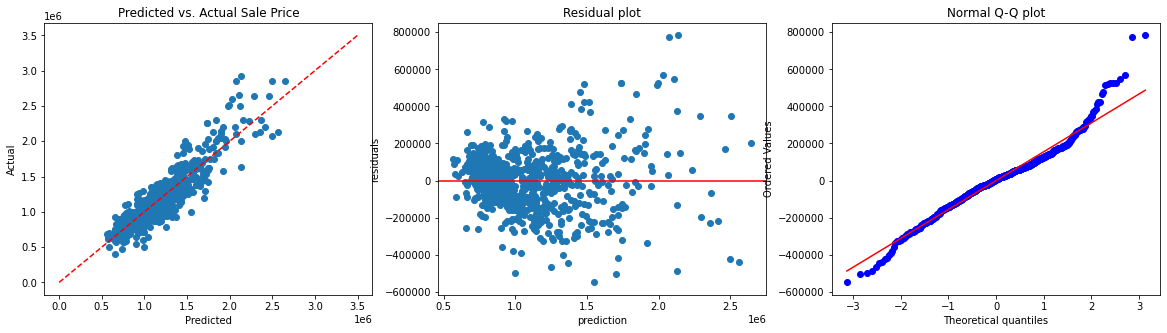

In [73]:
model_4.fit(X4_cv_scaled, y4_cv)

y4_pred = model_4.predict(X4_cv_scaled)

diagnostic_plots(X4_cv_scaled, y4_cv, y4_pred)

#### On a Mean MAE basis, this is on par w/ Model 2

### Model 5 - "Lazy" ElasticNet Regression (all the variables in the model)

In [55]:
X5 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')
X5_cv, X5_test, y5_cv, y5_test = train_test_split(X5, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X5_cv_scaled = scaler.fit_transform(X5_cv)

In [208]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l1_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]

elastic_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=1500000)

elastic_model.fit(X5_cv_scaled, y5_cv)

alpha = round(elastic_model.alpha_, 4)
print('Best alpha = {}'.format(alpha))
l1_ratio = round(elastic_model.l1_ratio_, 2)
print('Best L1 Ratio = {}'.format(l1_ratio))

Best alpha = 0.001
Best L1 Ratio = 0.7


In [56]:
model_5 = ElasticNet(alpha=0.001, l1_ratio=0.7, max_iter=1500000)

cv_rsquareds(X5_cv_scaled, y5_cv, model_5, 5)
cv_maes(X5_cv_scaled, y5_cv, model_5, 5)

CV R-squareds: [0.85, 0.833, 0.82, 0.769, 0.744]
Mean CV R-squared: 0.803 +/- 0.04

Adjusted CV R-squareds: [0.844, 0.826, 0.812, 0.759, 0.733]
Mean Adjusted CV R-squared: 0.795 +/- 0.042

CV MAEs: [130860, 120901, 117842, 107545, 122969]
Mean CV MAE: 120023 +/- 7581


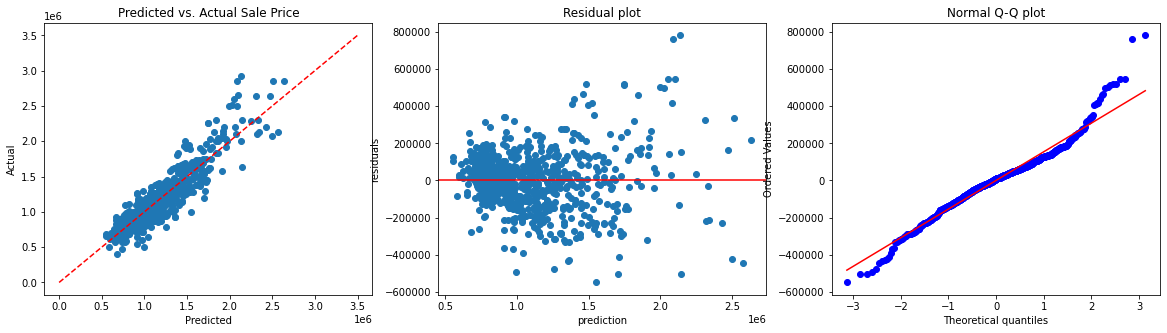

In [74]:
model_5.fit(X5_cv_scaled, y5_cv)

y5_pred = model_5.predict(X5_cv_scaled)

diagnostic_plots(X5_cv_scaled, y5_cv, y5_pred)

#### This looks like the best yet (on a Mean CV MAE basis)

In [219]:
list(zip(X5_cv.columns, model_5.coef_))

[('beds', 53951.5920146519),
 ('baths', 24167.724054110084),
 ('hm_sqft', 107413.02793499285),
 ('lot_size', 172298.16248859838),
 ('yr_built', 3981.36886276195),
 ('garage', -1055.1362706698317),
 ('one_story', 25277.851469197652),
 ('schools', -141488.52097234153),
 ('hoa', 1416.6186175574144),
 ('zipcode_91303', -31185.50348181138),
 ('zipcode_91304', -75067.46658223978),
 ('zipcode_91306', -60370.07728851884),
 ('zipcode_91307', -84076.63722756067),
 ('zipcode_91311', -63140.565904173614),
 ('zipcode_91316', 24452.96349375379),
 ('zipcode_91324', -38494.0641665786),
 ('zipcode_91325', -68605.01148984506),
 ('zipcode_91326', -69015.89908118868),
 ('zipcode_91335', -46708.35170536322),
 ('zipcode_91343', -80534.14476317118),
 ('zipcode_91344', -97973.43494667616),
 ('zipcode_91356', -4676.267446921401),
 ('zipcode_91364', -44920.11502524025),
 ('zipcode_91367', -48739.008772695764),
 ('zipcode_91406', -63248.98856889227),
 ('zipcode_91436', 32203.278164892294),
 ('beds_SQ', -66025.88

In [220]:
var_magnitudes = sorted(list(zip(X5_cv.columns, model_5.coef_)), key=lambda x: x[1])

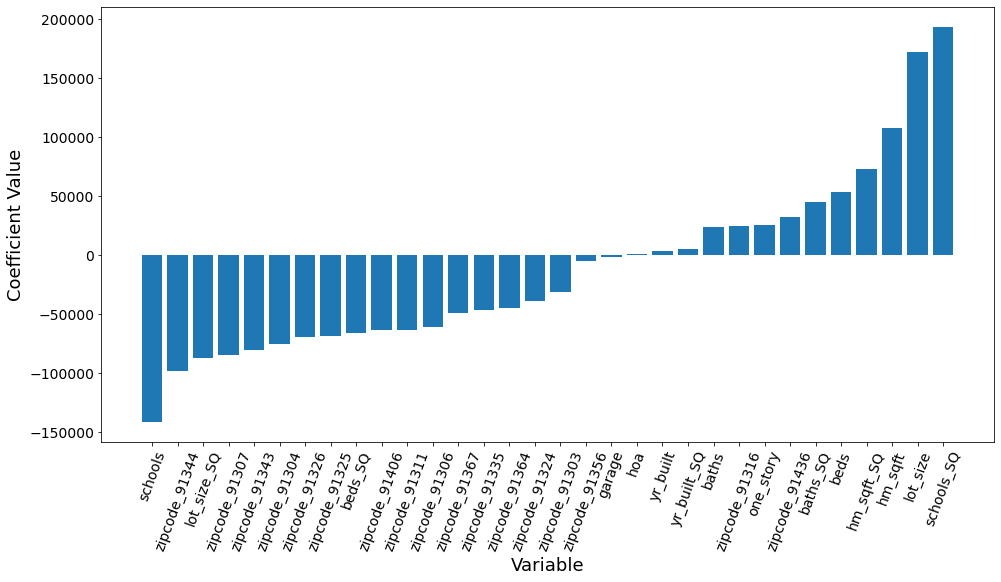

In [212]:
plt.figure(figsize=(16,8))
plt.bar(range(len(var_magnitudes)), [val[1] for val in var_magnitudes], align='center')
plt.xticks(range(len(var_magnitudes)), [val[0] for val in var_magnitudes])
plt.xticks(rotation=70, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Variable', fontsize=18)
plt.ylabel('Coefficient Value', fontsize=18)
plt.show()

In [224]:
X5_cv_scaled[0]

array([ 0.46039717,  0.58051815,  0.33392887, -0.27152612,  1.45515338,
       -0.41093711, -2.19322114,  0.65198815, -0.11014995, -0.14322297,
       -0.2880854 , -0.2112331 , -0.27772515, -0.19094065, -0.23896634,
       -0.14322297, -0.2239016 ,  3.82202082, -0.23896634, -0.24765567,
       -0.35029707, -0.2046578 , -0.36592777, -0.32252471, -0.28293864,
       -0.13380139,  0.32065466,  0.36528381,  0.12263283, -0.31495982,
        0.61548229,  1.452118  ])

In [232]:
coeffs = [val[1] for val in list(zip(X5_cv.columns, model_5.coef_))]
pred = []
for n in range(len(X5_cv_scaled[0])):
    pred.append(X5_cv_scaled[0][n] * coeffs[n])
np.sum(pred) + model_5.intercept_

1075238.2359587823

### Model 6: Random Forest Regression

In [58]:
X6 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')
X6_cv, X6_test, y6_cv, y6_test = train_test_split(X6, y, test_size=0.2, random_state=42)

In [234]:
grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]}

model_rf = RandomForestRegressor()

rf_gridsearch = RandomizedSearchCV(estimator = model_rf, 
                                   param_distributions = grid, 
                                   n_iter = 500, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

rf_gridsearch.fit(X6_cv, y6_cv)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='r2')

In [235]:
rf_gridsearch.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [236]:
# Updated/narrowed-down grid based on the results found by randomized search above
grid = {'n_estimators': [350, 400, 450, 500],
        'max_features': ['sqrt'],
        'max_depth': [45, 50, 55],
        'min_samples_split': [3, 4, 5, 6, 7],
        'min_samples_leaf': [1, 2, 3],
        'bootstrap': [False]}

# Perform grid search
grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X6_cv, y6_cv)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [45, 50, 55],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [3, 4, 5, 6, 7],
                         'n_estimators': [350, 400, 450, 500]})

In [237]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 55,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 450}

In [59]:
model_6 = RandomForestRegressor(
    n_estimators=450,
    min_samples_split=6,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=55,
    bootstrap=False
)

cv_rsquareds(X6_cv, y6_cv, model_6, 5)
cv_maes(X6_cv, y6_cv, model_6, 5)

CV R-squareds: [0.841, 0.792, 0.791, 0.687, 0.76]
Mean CV R-squared: 0.774 +/- 0.051

Adjusted CV R-squareds: [0.834, 0.783, 0.782, 0.674, 0.75]
Mean Adjusted CV R-squared: 0.765 +/- 0.053

CV MAEs: [125220, 121521, 127638, 121931, 112745]
Mean CV MAE: 121811 +/- 5057


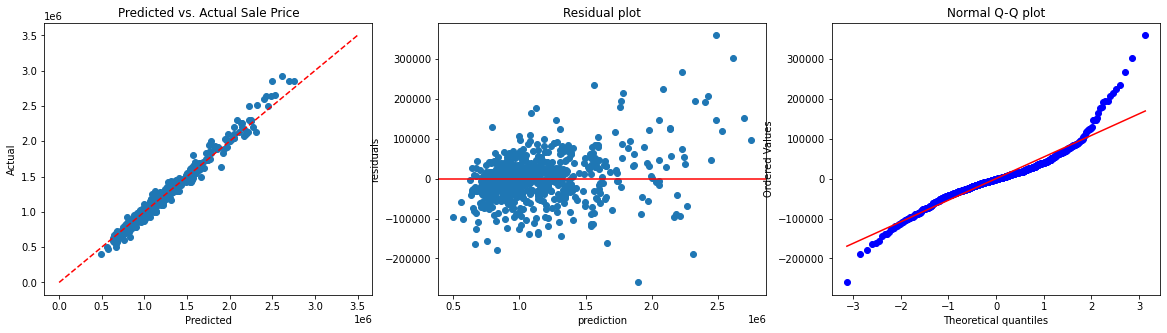

In [75]:
model_6.fit(X6_cv, y6_cv)

y6_pred = model_6.predict(X6_cv)

diagnostic_plots(X6_cv, y6_cv, y6_pred)

In [244]:
feature_importances = sorted(list(zip(X6_cv.columns, model_6.feature_importances_)), 
                             key=lambda x: x[1],
                             reverse=True)
feature_importances

[('hm_sqft', 0.1806730129400442),
 ('hm_sqft_SQ', 0.17921280611134657),
 ('baths_SQ', 0.09829924933491663),
 ('lot_size', 0.09547652155054312),
 ('lot_size_SQ', 0.09367312567455947),
 ('baths', 0.08412191634294831),
 ('schools_SQ', 0.045786528668332015),
 ('schools', 0.04187936686138937),
 ('beds', 0.02897714445376944),
 ('beds_SQ', 0.025810098602996986),
 ('yr_built_SQ', 0.02445617743299219),
 ('yr_built', 0.024338369861880458),
 ('zipcode_91316', 0.015005717974437038),
 ('zipcode_91436', 0.013624660789337308),
 ('zipcode_91364', 0.007346594207419923),
 ('zipcode_91356', 0.006497102884357419),
 ('one_story', 0.005842410598889442),
 ('zipcode_91367', 0.004850014379235544),
 ('zipcode_91325', 0.003103883772497613),
 ('zipcode_91344', 0.0030699807319479596),
 ('zipcode_91343', 0.0027426327265642836),
 ('zipcode_91326', 0.002310150071756713),
 ('zipcode_91307', 0.00194842144786836),
 ('zipcode_91406', 0.001908308926213744),
 ('garage', 0.0018454754276289766),
 ('zipcode_91306', 0.00177428

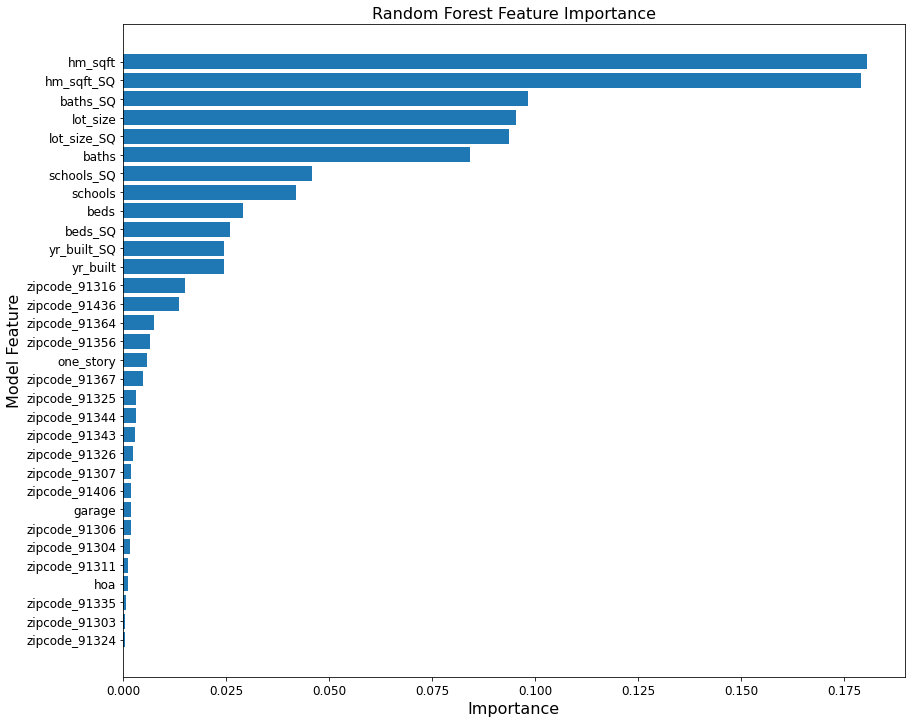

In [281]:
sorted_idx = model_6.feature_importances_.argsort()
plt.figure(figsize=(14, 12))
plt.barh(X6_cv.columns[sorted_idx], model_6.feature_importances_[sorted_idx])
plt.title('Random Forest Feature Importance', fontsize=16)
plt.xlabel("Importance", fontsize=16)
plt.xticks(fontsize='12')
plt.ylabel("Model Feature", fontsize=16)
plt.yticks(fontsize='12');

### Model 7 - XGBoost

In [61]:
X7 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')
X7_cv, X7_test, y7_cv, y7_test = train_test_split(X7, y, test_size=0.2, random_state=42)

In [253]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

grid = {
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 2, 3, 5],
        'subsample': [0.3, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.5, 0.7],
        'n_estimators' : [100, 200, 500, 1000],
        'objective': ['reg:squarederror', 'reg:pseudohubererror']
}

model_xgb = xgboost.XGBRegressor()

xgb_gridsearch = RandomizedSearchCV(estimator = model_xgb, 
                                   param_distributions = grid, 
                                   n_iter = 200, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

xgb_gridsearch.fit(X7_cv, y7_cv)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
   

In [254]:
xgb_gridsearch.best_params_

{'subsample': 0.5,
 'objective': 'reg:squarederror',
 'n_estimators': 1000,
 'min_child_weight': 2,
 'max_depth': 5,
 'learning_rate': 0.01,
 'colsample_bytree': 0.3}

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

In [256]:
# Updated/narrowed-down grid based on the results found by randomized search above
grid = {
        'learning_rate': [0.001, 0.005, 0.01],
        'max_depth': [4, 5, 6],
        'min_child_weight': [1, 2, 3],
        'subsample': [0.4, 0.5, 0.6],
        'colsample_bytree': [0.2, 0.3, 0.4],
        'n_estimators' : [900, 1000, 1200],
        'objective': ['reg:squarederror']
}

# Perform grid search
grid_search = GridSearchCV(estimator = xgboost.XGBRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X7_cv, y7_cv)

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [257]:
grid_search.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 1200,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

In [65]:
# Need this to filter annoying warnings (known bug/'feature' of XGBoost)
warnings.filterwarnings(action='ignore', category=UserWarning)

# model_xgb = xgboost.XGBRegressor(objective='reg:pseudohubererror', random_state=42)
model_7 = xgboost.XGBRegressor(
        subsample=0.5,
        objective='reg:squarederror',
        n_estimators=1200,
        min_child_weight=3,
        max_depth=4,
        learning_rate=0.01,
        colsample_bytree=0.4
)

cv_rsquareds(X7_cv, y7_cv, model_7, 5)
cv_maes(X7_cv, y7_cv, model_7, 5)

CV R-squareds: [0.868, 0.837, 0.832, 0.75, 0.783]
Mean CV R-squared: 0.814 +/- 0.042

Adjusted CV R-squareds: [0.862, 0.83, 0.825, 0.74, 0.774]
Mean Adjusted CV R-squared: 0.806 +/- 0.043

CV MAEs: [116267, 108986, 113750, 109788, 111618]
Mean CV MAE: 112082 +/- 2659


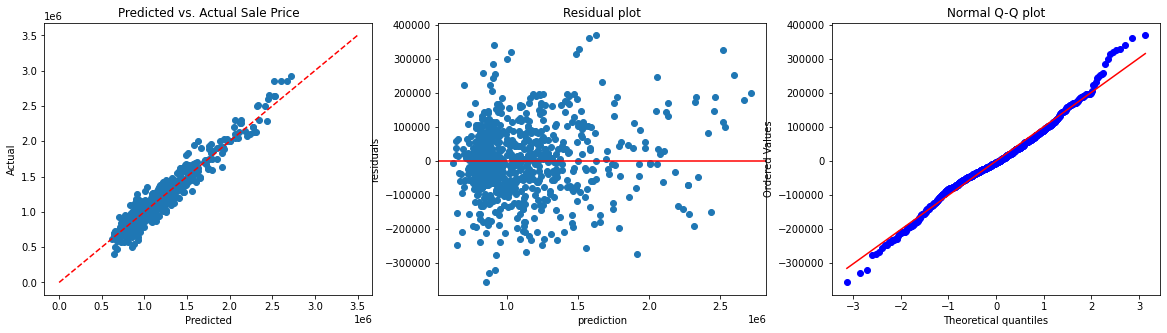

In [76]:
model_7.fit(X7_cv, y7_cv)

y7_pred = model_7.predict(X7_cv)

diagnostic_plots(X7_cv, y7_cv, y7_pred)

In [67]:
model_7.get_booster().get_score(importance_type="gain")

{'baths': 537658505156.66394,
 'schools_SQ': 175139051228.8159,
 'hm_sqft_SQ': 612343357669.4744,
 'beds_SQ': 90766079158.14433,
 'zipcode_91344': 150783797581.3187,
 'hm_sqft': 421140667927.75195,
 'lot_size': 272860794635.7132,
 'schools': 149664797714.70276,
 'lot_size_SQ': 273931067342.06244,
 'zipcode_91326': 108097705374.63414,
 'zipcode_91306': 56445912586.94444,
 'zipcode_91316': 229660216449.57297,
 'beds': 89085003299.72815,
 'zipcode_91436': 255952225348.85965,
 'baths_SQ': 308372262681.44885,
 'zipcode_91406': 81603471654.50981,
 'zipcode_91343': 95832642235.53659,
 'zipcode_91335': 45276077211.71429,
 'yr_built': 77015693428.46405,
 'zipcode_91311': 59075589875.757576,
 'zipcode_91325': 151702111951.04,
 'zipcode_91307': 90529676174.26967,
 'zipcode_91364': 103516260723.93259,
 'zipcode_91324': 51253460300.0,
 'one_story': 101552014560.0752,
 'zipcode_91304': 156565012568.46155,
 'yr_built_SQ': 72260309665.26869,
 'zipcode_91356': 150303906340.1613,
 'zipcode_91367': 93273

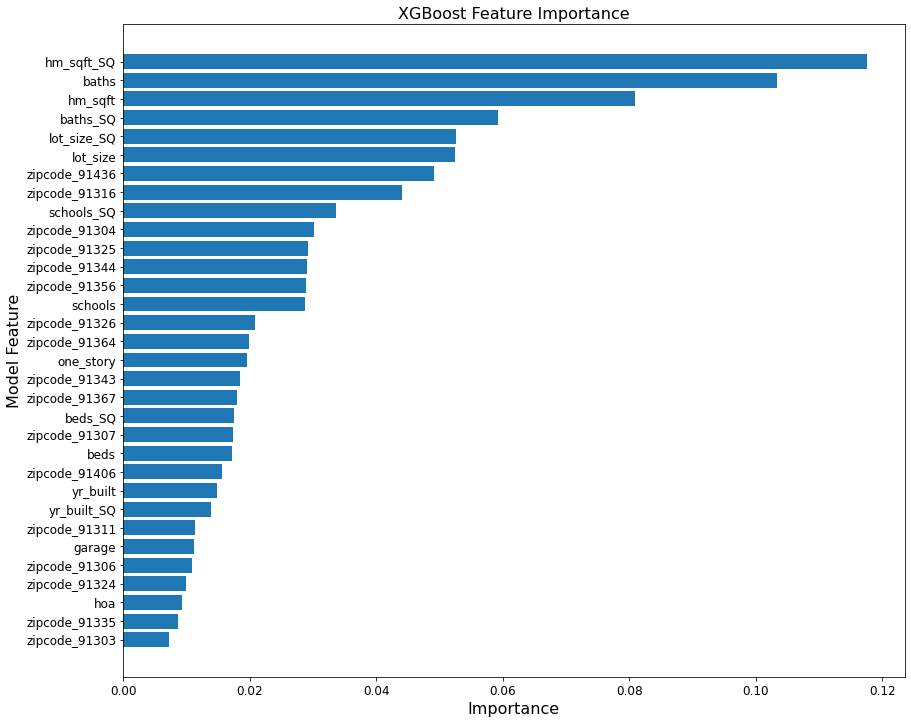

In [282]:
sorted_idx = model_7.feature_importances_.argsort()
plt.figure(figsize=(14, 12))
plt.barh(X7_cv.columns[sorted_idx], model_7.feature_importances_[sorted_idx])
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel("Importance", fontsize=16)
plt.xticks(fontsize='12')
plt.ylabel("Model Feature", fontsize=16)
plt.yticks(fontsize='12');

In [ ]:
feature_importances = sorted(list(zip(X7_cv.columns, model_7.feature_importances_)), 
                             key=lambda x: x[1],
                             reverse=True)
feature_importances